In [1]:
%matplotlib inline

In [2]:
from pynq import Xlnk
from pynq import Overlay
from pynq import DefaultIP
from pynq import DefaultHierarchy
xlnk = Xlnk()

In [3]:
from skimage import measure
from skimage.io import imread
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.filters import threshold_otsu
import cv2
import numpy as np
from PIL import Image
import time

In [4]:
class LabelAccelerate(DefaultHierarchy):
    def __init__(self, description):
        super().__init__(description=description)
        
    #bindto = ['xilinx.com:hls:hw_label_accel:1.0']
       
    def hw_label_f(self, image):
        (height, width) = image.shape
        self.label_accel.write(0x10, height)
        self.label_accel.write(0x18, width)
        with xlnk.cma_array(shape=(height, width), \
                            dtype=np.uint8, cacheable=1) as in_buffer,\
             xlnk.cma_array(shape=(height, width), \
                            dtype=np.uint16, cacheable=1) as out_buffer:
            
            in_buffer[0:height*width] = image
            self.label_dma.sendchannel.transfer(in_buffer)
            self.label_dma.recvchannel.transfer(out_buffer)
            self.label_accel.write(0x00,0x81) # start
            
            self.label_dma.sendchannel.wait()
            self.label_dma.recvchannel.wait()
            
        return out_buffer
    @staticmethod
    def checkhierarchy(description):
        if 'label_dma' in description['ip'] \
           and 'label_accel' in description['ip']:
            return True
        return False
    

In [5]:
image_path = "images/car.jpg"
imagepaths = ["images/car0.jpg", "images/car1.jpg", "images/car2.jpg", "images/car3.jpg", "images/car4.jpg",
              "images/car5.jpg", "images/car6.jpg", "images/car7.jpg", "images/car8.jpg", "images/car9.jpg" ]

In [6]:
gray_car_images = []
for idx in range(len(imagepaths)):
    imagepath = imagepaths[idx]
    gray_car_image = cv2.imread(imagepath, 0)
    gray_car_images.append(gray_car_image)

In [7]:
binary_car_images = []
for idx in range(len(imagepaths)):
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax1.imshow(gray_car_image, cmap="gray")
    threshold_value = threshold_otsu(gray_car_images[idx])
    binary_car_image = (gray_car_images[idx] > threshold_value) *255
    binary_car_images.append(binary_car_image)
    #ax2.imshow(binary_car_image, cmap="gray")
    #plt.show()

In [8]:
height, width = binary_car_image.shape
print("Image size: {}x{} pixels.".format(width, height))

Image size: 472x303 pixels.


In [9]:
for idx in range(len(imagepaths)):
    start = time.time()
    label_image_sw = measure.label(binary_car_images[idx])
    end = time.time()
    print(end - start)

0.016510725021362305
0.015825510025024414
0.01642632484436035
0.013448953628540039
0.01260066032409668
0.019206523895263672
0.014343023300170898
0.017320632934570312
0.014812469482421875
0.01422262191772461


In [10]:
design = Overlay("label.bit")
for idx in range(len(imagepaths)):
    start = time.time()
    label_image_hw = design.hw_label_accel.hw_label_f(binary_car_images[idx])
    end = time.time()
    print(end - start)

0.053406715393066406
0.045218706130981445
0.06159853935241699
0.04402518272399902
0.038800716400146484
0.07711100578308105
0.04973244667053223
0.06786131858825684
0.05170273780822754
0.04935717582702637


In [11]:
plate_dimensions = (0.04*label_image_hw.shape[0], 0.1*label_image_hw.shape[0], 0.15*label_image_hw.shape[1], 0.4*label_image_hw.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions

In [12]:
plate_objects_cordinates_hw = []
plate_like_objects_hw = []
for region in regionprops(label_image_hw):
        if region.area < 50:
            continue
        Min_row, Min_col, Max_row, Max_col = region.bbox
        region_height = Max_row - Min_row
        region_width = Max_col - Min_col
        ratio = float(region_width) / region_height
        if(3<ratio<5 
        and max_height >= region_height >= min_height 
        and max_width >= region_width >= min_width):
            plate_like_objects_hw.append(binary_car_image[Min_row:Max_row, Min_col:Max_col])
            plate_objects_cordinates_hw.append((Min_row, Min_col, Max_row, Max_col))

In [13]:
plate_objects_cordinates_sw = []
plate_like_objects_sw = []
for region in regionprops(label_image_sw):
        if region.area < 50:
            continue
        Min_row, Min_col, Max_row, Max_col = region.bbox
        region_height = Max_row - Min_row
        region_width = Max_col - Min_col
        ratio = float(region_width) / region_height
        if(3<ratio<5 
        and max_height >= region_height >= min_height 
        and max_width >= region_width >= min_width):
            plate_like_objects_sw.append(binary_car_image[Min_row:Max_row, Min_col:Max_col])
            plate_objects_cordinates_sw.append((Min_row, Min_col, Max_row, Max_col))

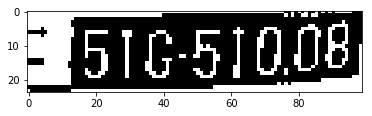

In [14]:
for i in range(len(plate_like_objects_hw)):
    plt.imshow(np.invert(plate_like_objects_hw[i]), cmap="gray")
    plt.show()

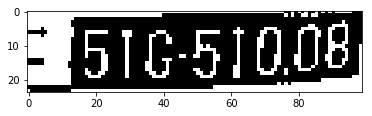

In [15]:
for i in range(len(plate_like_objects_sw)):
    plt.imshow(np.invert(plate_like_objects_sw[i]), cmap="gray")
    plt.show()

In [ ]:
xlnk.xlnk_reset()